In [1]:
pip install torchinfo

In [2]:
from IPython.core.display import JSON
from os import mkdir
!pip install -q kaggle
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

Saving kaggle.json to kaggle (2).json
kaggle.json


In [3]:
#kaggle datasets download -d alessiocorrado99/animals10   [kaggle api]

In [4]:
!kaggle datasets download -d alessiocorrado99/animals10
!unzip animals10.zip && rm animals10.zip

animals10.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  animals10.zip
replace raw-img/cane/OIF-e2bexWrojgtQnAPPcUfOWQ.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: raw-img/cane/OIF-e2bexWrojgtQnAPPcUfOWQ.jpeg  
replace raw-img/cane/OIP---A27bIBcUgX1qkbpZOPswHaFS.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: raw-img/cane/OIP---A27bIBcUgX1qkbpZOPswHaFS.jpeg  
replace raw-img/cane/OIP---ZIdwfUcJeVxnh47zppcQHaFj.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: raw-img/cane/OIP---ZIdwfUcJeVxnh47zppcQHaFj.jpeg  
replace raw-img/cane/OIP---ZRsOF7zsMqhW30WeF8-AHaFj.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace raw-img/cane/OIP---_cJbI6Ei26w5bW1urHewHaCf.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [5]:
import os
import time
import random
from glob import glob

import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image

import torch
import torchvision
import torch.nn as nn
from torch import optim
from torchvision import transforms, models, datasets
from torch.utils.data import DataLoader, Dataset, random_split, Subset

device = 'cuda' if torch.cuda.is_available() else 'cpu'

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [6]:
#defining the model which is vgg16
def get_model():

  model = models.vgg16(pretrained=True)
  for param in model.parameters():
    param.requires_grad = False
  model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
  model.classifier = nn.Sequential(nn.Flatten(),
                                   nn.Linear(512, 256),
                                   nn.ReLU(),
                                   nn.Dropout(0.2),
                                   nn.Linear(256,10))
  loss_fn = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)
  lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=2, eta_min=1e-5)
  return model.to(device), loss_fn, optimizer, lr_scheduler

In [7]:
from torch.optim import lr_scheduler
model, criterion, optimizer, lr_scheduler = get_model()

#if torchsummary is used
#from torchsummary import summary
#summary(model, input_size=(3, 224, 224))

#if summary from torchinfo is used (pip install torchinfo)
from torchinfo import summary
batch_size=32
summary(model, input_size=(batch_size, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      --                        --
├─Sequential: 1-1                        [32, 512, 7, 7]           --
│    └─Conv2d: 2-1                       [32, 64, 224, 224]        (1,792)
│    └─ReLU: 2-2                         [32, 64, 224, 224]        --
│    └─Conv2d: 2-3                       [32, 64, 224, 224]        (36,928)
│    └─ReLU: 2-4                         [32, 64, 224, 224]        --
│    └─MaxPool2d: 2-5                    [32, 64, 112, 112]        --
│    └─Conv2d: 2-6                       [32, 128, 112, 112]       (73,856)
│    └─ReLU: 2-7                         [32, 128, 112, 112]       --
│    └─Conv2d: 2-8                       [32, 128, 112, 112]       (147,584)
│    └─ReLU: 2-9                         [32, 128, 112, 112]       --
│    └─MaxPool2d: 2-10                   [32, 128, 56, 56]         --
│    └─Conv2d: 2-11                      [32, 256, 56, 56]   

In [8]:
model2 = models.vgg16(pretrained=True)
summary(model2, input_size=(batch_size, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      --                        --
├─Sequential: 1-1                        [32, 512, 7, 7]           --
│    └─Conv2d: 2-1                       [32, 64, 224, 224]        1,792
│    └─ReLU: 2-2                         [32, 64, 224, 224]        --
│    └─Conv2d: 2-3                       [32, 64, 224, 224]        36,928
│    └─ReLU: 2-4                         [32, 64, 224, 224]        --
│    └─MaxPool2d: 2-5                    [32, 64, 112, 112]        --
│    └─Conv2d: 2-6                       [32, 128, 112, 112]       73,856
│    └─ReLU: 2-7                         [32, 128, 112, 112]       --
│    └─Conv2d: 2-8                       [32, 128, 112, 112]       147,584
│    └─ReLU: 2-9                         [32, 128, 112, 112]       --
│    └─MaxPool2d: 2-10                   [32, 128, 56, 56]         --
│    └─Conv2d: 2-11                      [32, 256, 56, 56]         29

In [9]:
class CustomDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, index):
        if self.transform:
            x = self.transform(dataset[index][0])
        else:
            x = dataset[index][0]
        y = dataset[index][1]
        return x, y
    
    def __len__(self):
        return len(dataset)

In [10]:
'''
Creating data augmentation with transforms module of pytorch.
:transAug: Used for training data augmentation
transNoAug: Used for test and validation dataset. In this set, rotation and flipping is not practiced'''

transAug = transforms.Compose([transforms.RandomRotation(25),
                              transforms.RandomResizedCrop(224),
                              transforms.RandomHorizontalFlip(),
                              transforms.ToTensor(),
                              transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

transNoAug = transforms.Compose([transforms.Resize(225),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

In [11]:
#Reading the dataset from the downloaded folder

dataset = torchvision.datasets.ImageFolder('/content/raw-img')

traindataset = CustomDataset(dataset, transAug)
valdataset = CustomDataset(dataset, transNoAug)
testdataset = CustomDataset(dataset, transNoAug)

train_size = 0.8                                                    # 80% train size is used
num_train = len(dataset)
indices = list(range(num_train))
split = int(np.floor(train_size * num_train))                       # 80% range of training set
split2 = int(np.floor((train_size+(1-train_size)/2) * num_train))   # 10% range of test and validation
np.random.shuffle(indices)                                          # shuffling all the indices
train_idx, valid_idx, test_idx = indices[:split], indices[split:split2], indices[split2:]

traindata = Subset(traindataset, indices=train_idx)                 # creating subset of train set with
valdata = Subset(valdataset, indices=valid_idx)
testdata = Subset(testdataset, indices=test_idx)

batch_size=32
train_dl = DataLoader(traindata, num_workers=2, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(traindata, num_workers=2, batch_size=batch_size)
test_dl = DataLoader(traindata, num_workers=2, batch_size=1)

In [12]:
len(dataset)

26179

In [13]:
def get_lr(opt):

  for param_group in opt.param_groups:
    return param_group['lr']

In [14]:
def metrics_batch(output, target):
  #get output class

  pred = output.argmax(dim=1, keepdim=True)

  # compare output class with target class
  corrects=pred.eq(target.view_as(pred)).sum().item()
  return corrects

In [20]:
def loss_batch(loss_func, output, target, opt=None):
  # get loss
  loss = loss_func(output, target)

    # get performance metric
  metric_b = metrics_batch(output, target)

  if opt is not None:
    opt.zero_grad()
    loss.backward()
    opt.step()

  return loss.item(), metric_b

In [22]:
def loss_epoch(model, loss_func, dataset_dl, sanity_check=False, opt=None):
  running_loss=0.0
  running_metric=0.0
  len_data=len(dataset_dl.dataset)

  for xb, yb in dataset_dl:
    # move batch to device
    xb=xb.to(device)
    yb=yb.to(device)

    # get model output
    output=model(xb)

    # get loss per batch
    loss_b,metric_b=loss_batch(loss_func, output, yb, opt)

    # update running loss
    running_loss+=loss_b

    # update running metric
    if metric_b is not None:
      running_metric+=metric_b

    # break the loop in case of sanity check
    if sanity_check is True:
      break

  # average loss value
  loss=running_loss/float(len_data)

  #average metric value
  metric=running_metric/float(len_data)

  return loss, metric

In [17]:
def train_val(model, params):
  # extract model parameters

  num_epochs=params['num_epochs']
  loss_func=params['loss_func']
  opt=params['optimizer']
  train_dl=params['train_dl']
  val_dl=params['val_dl']
  sanity_check=params['sanity_check']
  lr_scheduler=params['lr_scheduler']
  path2weights=params['path2weights']

  # transfer the model to device 'GPU'
  model.to(device)

  # history of loss values in each epoch
  loss_history={
      "train": [],
      "val": [],
  }

  # history of metric values in each epoch
  metric_history={
      "train": [],
      "val": [],
  }

  # a deep copy of weights for the best performing model
  best_model_wts = copy.deepcopy(model.state_dict())

  # initialize best loss to a large value
  best_loss=float('inf')

  # main loop
  for epoch in range(num_epochs):

    # get current learning rate
    current_lr=get_lr(opt)
    print('Epoch {}/{}, current lr={}'.format(epoch, num_epochs - 1, current_lr))

    # train model on training dataset
    model.train()
    train_loss, train_metric=loss_epoch(model, loss_func, train_dl, sanity_check, opt)

    # collect loss and metric for training dataset
    loss_history["train"].append(train_loss)
    metric_history["train"].append(train_metric)

    # evaluate modelon validation dataset
    model.eval()
    with torch.no_grad():
      val_loss, val_metric=loss_epoch(model, loss_func, val_dl, sanity_check)

    # store best model
    if val_loss < best_loss:
      best_loss = val_loss
      best_model_wts = copy.deepcopy(model.state_dict())

      # store weights into a local file
      torch.save(model.state_dict(), path2weights)
      print("copied best model weights!")

    # collect loss and metric for validation dataset
    loss_history["val"].append(val_loss)
    metric_history["val"].append(val_metric)

    # learning rate schedule
    lr_scheduler.step()

    print("train loss: %.6f, validation loss: %.6f, accuracy: %.2f" %(train_loss, val_loss, 100*val_metric))
    print("-"*10)

  # load best model weights
  model. load_state_dict(best_model_wts)

  return model,loss_history, metric_history

In [18]:
!mkdir saved_models

mkdir: cannot create directory ‘saved_models’: File exists


TRAINING

In [23]:
import copy
model, criterion, opt, lr_scheduler = get_model()

params_train={
    "num_epochs": 5,
    "optimizer": opt,
    "loss_func": criterion,
    "train_dl": train_dl,
    "val_dl": val_dl,
    "sanity_check": False,
    "lr_scheduler": lr_scheduler,
    "path2weights": "/content/saved_models/vgg16_pretrained.pt",
}

# train and validate the model
model_pretrained,loss_hist,metric_hist=train_val(model,params_train)

Epoch 0/4, current lr=0.001
copied best model weights!
train loss: 0.017382, validation loss: 0.011992, accuracy: 87.29
----------
Epoch 1/4, current lr=0.000505
copied best model weights!
train loss: 0.012077, validation loss: 0.011186, accuracy: 88.14
----------
Epoch 2/4, current lr=1e-05
copied best model weights!
train loss: 0.011305, validation loss: 0.010885, accuracy: 88.36
----------
Epoch 3/4, current lr=0.0005049999999999999
copied best model weights!
train loss: 0.011640, validation loss: 0.010868, accuracy: 88.32
----------
Epoch 4/4, current lr=0.001
train loss: 0.011736, validation loss: 0.010938, accuracy: 88.39
----------


INFERENCE

In [24]:
def load_model(path2weights):
  model_vgg = models.vgg16(pretrained=False)
  for param in model_vgg.parameters():
    param.requires_grad = False
  model_vgg.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
  model_vgg.classifier = nn.Sequential(nn.Flatten(),
                                       nn.Linear(512, 256),
                                       nn.ReLU(),
                                       nn.Dropout(0.2),
                                       nn.Linear(256, 10))
  model_vgg.load_state_dict(torch.load(path2weights))
  return model_vgg.to(device)
  

In [25]:
path2weights="/content/saved_models/vgg16_pretrained.pt"
trained_model = load_model(path2weights)

In [28]:
def prediction(model, dataset, device, num_classes=10, sanity_check=False):

  len_data=len(test_dl.dataset)
  # initialize output tensor on CPU: due to GPU memory limits
  y_out=torch.zeros(len_data, num_classes)

  #initialize ground truth on CPU due to GPU memory limit
  y_gt=np.zeros((len_data), dtype="uint8")

  model.eval()

  device = 'cuda' if torch.cuda.is_available() else 'cpu'

  elapsed_times=[]
  with torch.no_grad():
    for ix, (data, target) in enumerate(dataset):
      x,y = data.cuda(), target.cpu()
      y_gt[ix]=y
      start=time.time()
      yy=model(x)
      y_out[ix]=torch.softmax(yy, dim=1)
      elapsed=time.time()-start
      elapsed_times.append(elapsed)

      if sanity_check is True:
        break

  inference_time=np.mean(elapsed_times)*1000
  print("average inference time per image on %s: %.2f ms " %(device, inference_time))
  return y_out.cpu().numpy(),y_gt






In [29]:
import time
import numpy as np

# deploy model
y_out, y_gt=prediction(trained_model, test_dl, device = device, sanity_check=False)
print(y_out.shape,y_gt.shape)

average inference time per image on cuda: 6.49 ms 
(20943, 10) (20943,)


In [32]:
from sklearn.metrics import accuracy_score

# get predictions
y_pred = np.argmax(y_out,axis=1)
print(y_pred.shape,y_gt.shape)

# compute accuracy 
acc=accuracy_score(y_pred,y_gt)
print("accuracy: %.2f%" %acc*100)

(20943,) (20943,)


ValueError: ignored

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

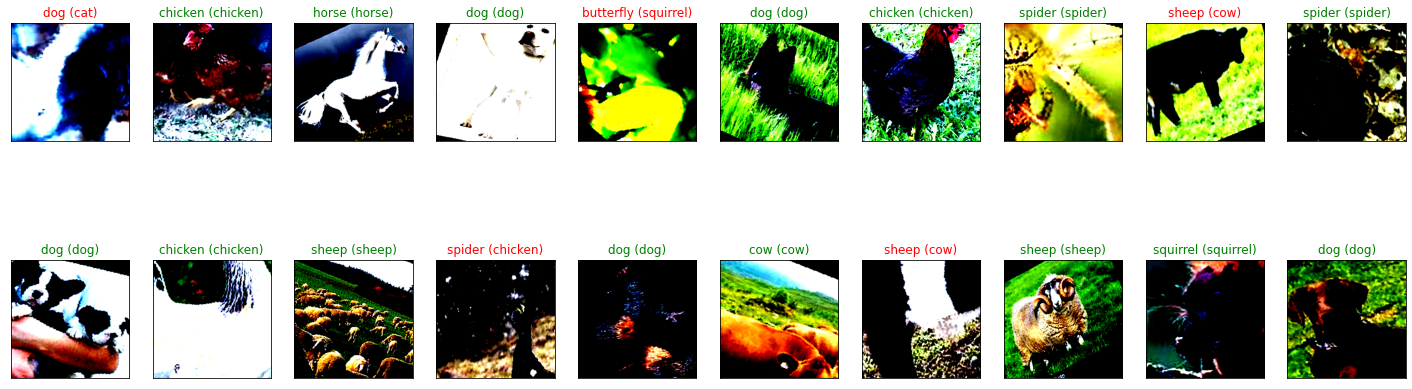

In [33]:
classes = ["cane", "cavallo", "elefante", "farfalla", "gallina", "gatto", "mucca", "pecora","ragno", "scoiattolo" ]
translate = {"cane": "dog", "cavallo": "horse", "elefante": "elephant", "farfalla": "butterfly",
             "gallina": "chicken", "gatto": "cat", "mucca": "cow", "pecora": "sheep", 
             "ragno": "spider", "scoiattolo": "squirrel" }

disimage = 20
num_classes = 10
# initialize output tensor on CPU: due to GPU memory limits
y_out=torch.zeros(disimage, num_classes)
images = torch.zeros((disimage, 3, 224, 224))
# initialize ground truth on CPU: due to GPU memory limits
y_predictions, y_gt = np.zeros((disimage),dtype="uint8"), np.zeros((disimage),dtype="uint8")
dataiter = iter(test_dl)

for ix in np.arange(disimage):
  image, label = dataiter.next()
  image = image.cuda()
  images[ix] = torch.squeeze(image)
  y_gt[ix] = label
  yy = trained_model(image)
  y_out = torch.softmax(yy, dim=1)
  _, preds_tensor = torch.max(y_out, 1)
  y_predictions[ix] = (np.squeeze(preds_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(preds_tensor.cpu().numpy()))


fig = plt.figure(figsize=(25, 8))
for idx in np.arange(disimage):
    ax = fig.add_subplot(2, disimage/2, idx+1, xticks=[], yticks=[])
    plt.imshow(images[idx].permute(1, 2, 0))
    ax.set_title("{} ({})".format(translate[classes[y_predictions[idx]]], translate[classes[y_gt[idx]]]),
                 color=("green" if y_predictions[idx]==y_gt[idx].item() else "red"))